In [1]:
### Resources:

# DQL Algorithm: https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm

# DQN Parameters: https://stable-baselines.readthedocs.io/en/master/modules/dqn.html

# DQN Paper: https://arxiv.org/abs/1312.5602

# Double DQN Paper: https://arxiv.org/abs/1509.06461

# Dueling DQN Paper: https://arxiv.org/abs/1511.06581

# Prioritized Experience Replay Paper: https://arxiv.org/abs/1511.05952
 

In [1]:
import gym
import torch
from torch import nn
import numpy as np
from spinup.utils.run_utils import setup_logger_kwargs

from models import MLPDQN
from train import DQNTrainer

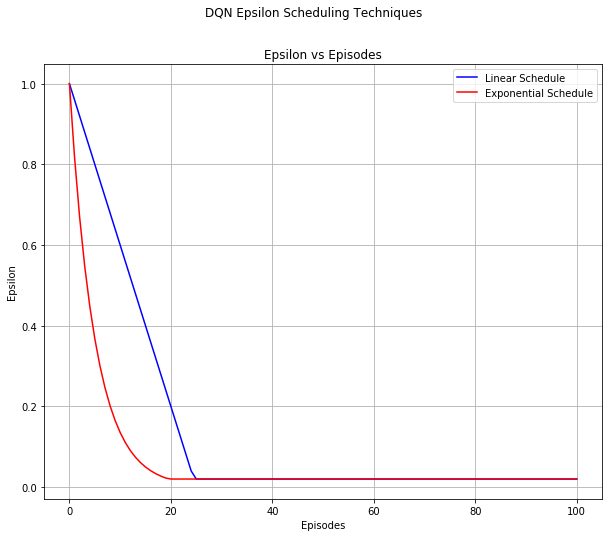

In [3]:
### Test different epsilon scheduling techniques

import matplotlib.pyplot as plt

eps_st, eps_end = 1.0, 0.02
episodes = np.arange(101)

# Schedule 1 (Linear)
eps_1 = np.zeros(episodes.shape, dtype=np.float32)
eps_1[0], decay_rate = eps_st, 0.04
for i in range(episodes.shape[0] - 1):
    eps_1[i+1] = max(eps_end, eps_1[i] - decay_rate)

# Schedule 2 (Exponential)
eps_2 = np.zeros(episodes.shape, dtype=np.float32)
eps_2[0], decay_rate = eps_st, 0.2
for i in range(episodes.shape[0] - 1):
    eps_2[i+1] = max(eps_end, eps_2[i] * np.exp(-decay_rate))

# Plot both schedules
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.suptitle('DQN Epsilon Scheduling Techniques')
ax.plot(episodes, eps_1, color='b', label='Linear Schedule')
ax.plot(episodes, eps_2, color='r', label='Exponential Schedule')
ax.set_title('Epsilon vs Episodes')
ax.set_xlabel('Episodes')
ax.set_ylabel('Epsilon')
ax.grid(True)
ax.legend()
plt.show()

In [4]:
net = nn.Sequential(nn.Linear(3, 32), nn.Tanh(), nn.Linear(32, 4))
obs = np.random.randn(64, 3)
act = np.random.randint(4, size=64)
q = net(torch.as_tensor(obs, dtype=torch.float32))
q_vals = q[torch.arange(q.shape[0]), act]
q_max, _ = torch.max(q, dim=-1)
print(q[:3], q_vals.shape, net(torch.zeros((1, 3), dtype=torch.float32)).shape)

arr = torch.arange(10)
mask = np.array([True, True, True, False, False, True, False, False, False, True], dtype=np.bool)
mask = torch.as_tensor(mask, dtype=torch.bool)
arr[mask] = -1
print(mask, arr)
r = torch.randint(0, arr.shape[-1], size=(1,))
print(type(act[0]))

a = torch.arange(50).reshape(5, 10)
b = torch.arange(5).reshape(5, 1)
print(a + b)

tensor([[ 0.4643, -0.2669, -0.2184,  0.2538],
        [-0.4051, -0.3087, -0.0033,  0.0349],
        [ 0.3554, -0.2782, -0.0838, -0.0603]], grad_fn=<SliceBackward>) torch.Size([64]) torch.Size([1, 4])
tensor([ True,  True,  True, False, False,  True, False, False, False,  True]) tensor([-1, -1, -1,  3,  4, -1,  6,  7,  8, -1])
<class 'numpy.int64'>
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        [33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
        [44, 45, 46, 47, 48, 49, 50, 51, 52, 53]])


In [5]:
### Test MLP DQN class for discrete environments 

env_discrete = gym.make('CartPole-v1')
hidden_sizes, hidden_acts = [64, 64], nn.Tanh
eps_init, eps_final, eps_decay_rate = 1.0, 0.02, 0.04
dqn = MLPDQN(env_discrete, eps_init, eps_final, 
              eps_decay_rate, hidden_sizes, hidden_acts)
print('DQN Summary \n\n')
dqn.layer_summary()

DQN Summary 


Linear input & output shapes:	 torch.Size([1, 4]) torch.Size([1, 64])
Tanh input & output shapes:	 torch.Size([1, 64]) torch.Size([1, 64])
Linear input & output shapes:	 torch.Size([1, 64]) torch.Size([1, 64])
Tanh input & output shapes:	 torch.Size([1, 64]) torch.Size([1, 64])
Linear input & output shapes:	 torch.Size([1, 64]) torch.Size([1, 2])




/home/sherif/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
### Test copying the weights from Q network to target Q network

env_discrete = gym.make('CartPole-v1')
hidden_sizes, hidden_acts = [6, 6], nn.Tanh
eps_init, eps_final, eps_decay_rate = 1.0, 0.02, 0.04
dqn = MLPDQN(env_discrete, eps_init, eps_final, 
              eps_decay_rate, hidden_sizes, hidden_acts)
obs = torch.randn((4, 4), dtype=torch.float32)

# Test after initialization
out = dqn.net(obs)
out_target = dqn.net_target(obs)
print(f'1) Outputs after initialization:\n\n{out}\n\n{out_target}\n\n')

# Change Q network and re-test
for param in dqn.net.parameters():
    param.data.copy_(torch.randn(param.data.size()))
out = dqn.net(obs)
out_target = dqn.net_target(obs)
print(f'2) Outputs after weight update:\n\n{out}\n\n{out_target}\n\n')

# Copy Q network weights into target Q network and re-test
dqn.update_target()
out = dqn.net(obs)
out_target = dqn.net_target(obs)
print(f'3) Outputs after target weight update:\n\n{out}\n\n{out_target}\n\n')

1) Outputs after initialization:

tensor([[-0.0072, -0.0080],
        [ 0.0059,  0.0064],
        [ 0.0048,  0.0048],
        [ 0.0083,  0.0082]], grad_fn=<AddmmBackward>)

tensor([[-0.0072, -0.0080],
        [ 0.0059,  0.0064],
        [ 0.0048,  0.0048],
        [ 0.0083,  0.0082]])


2) Outputs after weight update:

tensor([[ 1.1734, -2.2787],
        [ 2.4325,  0.1792],
        [-0.4505, -1.8464],
        [ 2.4636,  1.6571]], grad_fn=<AddmmBackward>)

tensor([[-0.0072, -0.0080],
        [ 0.0059,  0.0064],
        [ 0.0048,  0.0048],
        [ 0.0083,  0.0082]])


3) Outputs after target weight update:

tensor([[ 1.1734, -2.2787],
        [ 2.4325,  0.1792],
        [-0.4505, -1.8464],
        [ 2.4636,  1.6571]], grad_fn=<AddmmBackward>)

tensor([[ 1.1734, -2.2787],
        [ 2.4325,  0.1792],
        [-0.4505, -1.8464],
        [ 2.4636,  1.6571]])




In [6]:
### Define parameters needed for training

# DQN module parameters
hidden_sizes, hidden_acts = [64, 64], nn.Tanh
eps_init, eps_final, eps_decay_rate = 1.0, 0.02, 0.04
double_q = True
q_net_kwargs = dict(hidden_sizes=hidden_sizes, 
                    hidden_acts=hidden_acts)

# Training parameters
seed, buf_size = 0, 10000
steps_per_epoch, max_ep_len = 4000, 1000
batch_size, epochs = 128, 50 
learning_starts = 1000
train_freq, target_network_update_freq = 1, 500
gamma, q_lr = 0.99, 5e-4 
save_freq = 10

# Experiment parameters
data_dir = '/home/sherif/user/python/DRL/data/dqn'

In [7]:
### Start the training process using the custom DQN implementation for a Discrete environment

env_fn = lambda : gym.make('CartPole-v1')
exp_name_custom = 'dqn_custom_discrete'

logger_kwargs = setup_logger_kwargs(exp_name=exp_name_custom, data_dir=data_dir)

trainer = DQNTrainer()
trainer.train_mod(env_fn, double_q=double_q, q_net_kwargs=q_net_kwargs, seed=seed,
                  eps_init=eps_init, eps_final=eps_final, eps_decay_rate=eps_decay_rate, 
                  buf_size=buf_size, steps_per_epoch=steps_per_epoch, batch_size=batch_size,
                  epochs=epochs, max_ep_len=max_ep_len, learning_starts=learning_starts,
                  train_freq=train_freq, target_network_update_freq=target_network_update_freq,
                  gamma=gamma, q_lr=q_lr, logger_kwargs=logger_kwargs, save_freq=save_freq)

Logging data to /home/sherif/user/python/DRL/data/dqn/dqn_custom_discrete/progress.txt
Saving config:

{
    "batch_size":	128,
    "buf_size":	10000,
    "env":	{
        "<TimeLimit<CartPoleEnv<CartPole-v1>>>":	{
            "_elapsed_steps":	null,
            "_max_episode_steps":	500,
            "action_space":	{
                "Discrete(2)":	{
                    "dtype":	"int64",
                    "n":	2,
                    "np_random":	"RandomState(MT19937)",
                    "shape":	[]
                }
            },
            "env":	{
                "<CartPoleEnv<CartPole-v1>>":	{
                    "action_space":	{
                        "Discrete(2)":	{
                            "dtype":	"int64",
                            "n":	2,
                            "np_random":	"RandomState(MT19937)",
                            "shape":	[]
                        }
                    },
                    "force_mag":	10.0,
                    "gravity":	9.8,
